<a href="https://colab.research.google.com/github/vijayshankarrealdeal/intro_to_pytorch-Gans/blob/main/Pytorch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/PacktWorkshops/The-Deep-Learning-with-PyTorch-Workshop/master/Chapter02/Exercise2.02/energydata_complete.csv

--2021-07-25 13:26:39--  https://raw.githubusercontent.com/PacktWorkshops/The-Deep-Learning-with-PyTorch-Workshop/master/Chapter02/Exercise2.02/energydata_complete.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11979363 (11M) [text/plain]
Saving to: ‘energydata_complete.csv.10’

energydata_complete 100%[===================>]  11.42M  --.-KB/s    in 0.09s   

2021-07-25 13:26:39 (126 MB/s) - ‘energydata_complete.csv.10’ saved [11979363/11979363]



In [2]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


In [111]:
"""
The Appliances energy prediction Dataset contains 4.5 months of data related to temperature and humidity measures
for different rooms in a low-energy building, with the objective of predicting the energy 
that's used by certain appliances
"""

"\nThe Appliances energy prediction Dataset contains 4.5 months of data related to temperature and humidity measures\nfor different rooms in a low-energy building, with the objective of predicting the energy \nthat's used by certain appliances\n"

In [3]:
df = pd.read_csv('/content/energydata_complete.csv')
df = df.drop(['date'],axis = 1)

In [4]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [5]:
Y = df['Appliances']
X = df.iloc[:,1:]

In [6]:
sample = df.head()

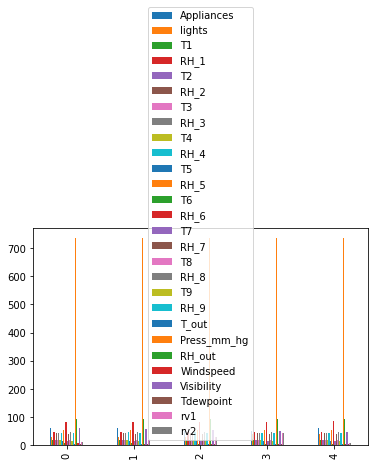

In [7]:
sample.plot.bar()

In [115]:
X = (X - X.min()) / (X.max() - X.min())
X.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,0.428571,0.32735,0.566187,0.225345,0.684038,0.215188,0.746066,0.351351,0.764262,0.175506,0.381691,0.381070,0.841827,0.170594,0.653428,0.173329,0.661412,0.223032,0.677290,0.372990,0.097674,0.894737,0.500000,0.953846,0.538462,0.265449,0.265449
1,0.428571,0.32735,0.541326,0.225345,0.682140,0.215188,0.748871,0.351351,0.782437,0.175506,0.381691,0.375443,0.839872,0.170594,0.651064,0.173329,0.660155,0.226500,0.678532,0.369239,0.100000,0.894737,0.476190,0.894872,0.533937,0.372083,0.372083
2,0.428571,0.32735,0.530502,0.225345,0.679445,0.215188,0.755569,0.344745,0.778062,0.175506,0.380037,0.367487,0.830704,0.170594,0.646572,0.173329,0.655586,0.219563,0.676049,0.365488,0.102326,0.894737,0.452381,0.835897,0.529412,0.572848,0.572848
3,0.571429,0.32735,0.524080,0.225345,0.678414,0.215188,0.758685,0.341441,0.770949,0.175506,0.380037,0.363800,0.833401,0.164310,0.641489,0.164175,0.650788,0.219563,0.671909,0.361736,0.104651,0.894737,0.428571,0.776923,0.524887,0.908261,0.908261
4,0.571429,0.32735,0.531419,0.225345,0.676727,0.215188,0.758685,0.341441,0.762697,0.178691,0.380037,0.361859,0.848264,0.170594,0.639362,0.164175,0.650788,0.219563,0.671909,0.357985,0.106977,0.894737,0.404762,0.717949,0.520362,0.201611,0.201611


In [132]:
X = (X - X.mean())/X.std()
X.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,3.301180,-1.118616,1.843774,-0.520398,1.073656,-1.235032,1.686087,-0.908194,1.506399,-1.314870,0.471148,-0.145193,0.951774,-1.453610,1.219830,-1.957459,1.141543,-1.217293,0.958112,-0.152643,-2.976252,0.82206,1.207663,2.091543,0.366966,-0.807953,-0.807953
1,3.301180,-1.118616,1.616766,-0.520398,1.057071,-1.235032,1.704523,-0.908194,1.604488,-1.314870,0.471148,-0.176937,0.945568,-1.453610,1.206795,-1.957459,1.134525,-1.200748,0.965338,-0.174583,-2.962738,0.82206,1.071676,1.766539,0.343126,-0.440229,-0.440229
2,3.301180,-1.118616,1.517921,-0.520398,1.033523,-1.235032,1.748563,-0.944091,1.580878,-1.314870,0.458956,-0.221816,0.916461,-1.453610,1.182027,-1.957459,1.109004,-1.233838,0.950886,-0.196524,-2.949223,0.82206,0.935690,1.441535,0.319286,0.252102,0.252102
3,4.561263,-1.118616,1.459284,-0.520398,1.024514,-1.235032,1.769047,-0.962039,1.542487,-1.314870,0.458956,-0.242614,0.925022,-1.485205,1.154001,-2.008580,1.082206,-1.233838,0.926798,-0.218464,-2.935709,0.82206,0.799703,1.116531,0.295446,1.408765,1.408765
4,4.561263,-1.118616,1.526298,-0.520398,1.009771,-1.235032,1.769047,-0.962039,1.497953,-1.296799,0.458956,-0.253561,0.972213,-1.453610,1.142269,-2.008580,1.082206,-1.233838,0.926798,-0.240405,-2.922194,0.82206,0.663716,0.791527,0.271606,-1.028096,-1.028096


<BarContainer object of 27 artists>

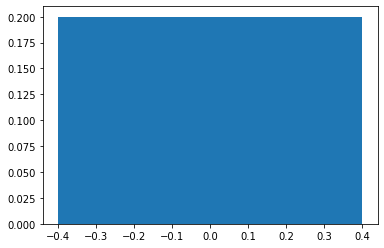

In [116]:
train_end = int(len(X) * 0.6)
dev_end = int(len(X) * 0.8)

In [117]:
X_shuffle = X.sample(frac=1, random_state=0)
Y_shuffle = Y.sample(frac=1, random_state=0)

In [118]:
x_train = X_shuffle.iloc[:train_end,:]
y_train = Y_shuffle.iloc[:train_end]
x_dev = X_shuffle.iloc[train_end:dev_end,:]
y_dev = Y_shuffle.iloc[train_end:dev_end]
x_test = X_shuffle.iloc[dev_end:,:]
y_test = Y_shuffle.iloc[dev_end:]

In [119]:
print(x_train.shape, y_train.shape)
print(x_dev.shape, y_dev.shape)
print(x_test.shape, y_test.shape)

(11841, 27) (11841,)
(3947, 27) (3947,)
(3947, 27) (3947,)


In [120]:
from sklearn.model_selection import train_test_split

In [121]:
x_new, x_test_2, \
y_new, y_test_2 = train_test_split(X_shuffle, Y_shuffle, \
                                   test_size=0.2, \
random_state=0)
dev_per = x_test_2.shape[0]/x_new.shape[0]
x_train_2, x_dev_2, \
y_train_2, y_dev_2 = train_test_split(x_new, y_new, \
                                      test_size=dev_per, \
random_state=0)

In [122]:
x_train = torch.tensor(x_train.values).float()
y_train = torch.tensor(y_train.values).float()
x_dev = torch.tensor(x_dev.values).float()
y_dev = torch.tensor(y_dev.values).float()
x_test = torch.tensor(x_test.values).float()
y_test = torch.tensor(y_test.values).float()

In [123]:
class Network(nn.Module):
  def __init__(self,input=27,output=1,hidden_dims= 30):
    super(Network,self).__init__()
    self.gen = nn.Sequential(
        nn.Linear(input,hidden_dims*2),
        nn.ReLU(),
        nn.Linear(hidden_dims*2,hidden_dims),
        nn.ReLU(),
        nn.Linear(hidden_dims,output),
    )
  def forward(self,x):
    return self.gen(x)


In [124]:
num_iter =  5000
losses = []
model = Network(x_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(),lr= 0.001)
loss_fn = torch.nn.MSELoss()  

In [125]:
for i in range(num_iter):
  y_hat = model(x_train).squeeze()
  loss = loss_fn(y_hat,y_train)
  losses.append(loss.item())
  if i% 100 == 0:
    print(loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

20299.5
14879.4072265625
10840.228515625
10779.482421875
10677.2939453125
10513.0263671875
10311.7265625
10095.6591796875
9882.31640625
9692.98046875
9541.412109375
9430.9140625
9352.2666015625
9284.23828125
9228.5615234375
9179.7919921875
9131.8955078125
9082.9287109375
9030.7470703125
8988.2568359375
8949.484375
8915.47265625
8884.2890625
8857.119140625
8832.9921875
8809.7939453125
8788.08203125
8767.3759765625
8746.8818359375
8726.701171875
8706.3701171875
8688.5107421875
8671.185546875
8655.314453125
8639.88671875
8624.5654296875
8597.69140625
8569.2197265625
8544.689453125
8521.259765625
8499.5283203125
8479.486328125
8454.7158203125
8418.408203125
8391.4033203125
8364.798828125
8343.384765625
8323.9755859375
8306.8662109375
8290.3994140625


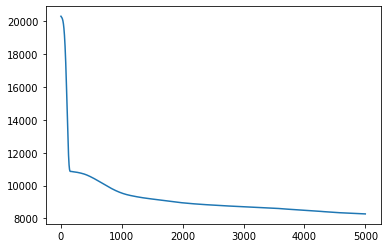

In [126]:
plt.plot(range(num_iter),losses)

In [129]:
pred = model(x_test[20])
print("Ground truth:", y_test[20].item(), 
      "Prediction:",pred.item())

Ground truth: 120.0 Prediction: 44.08254623413086
